In [ ]:
# import packages
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

from rdrobust import rdrobust


In [10]:
data_folder = 'Data Task Files'
revenue_path = os.path.join(data_folder, 'Revenue.txt')

In [11]:
# revenue is a fixed width file
revenue_df = pd.read_fwf(revenue_path,colspecs=[(0, 10), (10, 14), (14, 16)],names=['logrev', 'rest_id', 'time'],header=None)
print(revenue_df.head())

    logrev  rest_id  time
0  1.63390        1     1
1  1.43880        2     1
2  6.20120        3     1
3 -0.34747        4     1
4 -0.22975        5     1


In [12]:
# revenue_df[revenue_df['rest_id']==1] # check the data - monthly revenue for restaurant 1

In [13]:
# combine all the monthly data (each month has the rest_id, score and stars)
monthly_data = []

for i in range(1, 11):
    filename = f'month{i:02d}.csv'
    file_path = os.path.join(data_folder, filename)
    df_month = pd.read_csv(file_path)
    monthly_data.append(df_month)

In [14]:
# concat all the monthly data
stars_df = pd.concat(monthly_data, ignore_index=True)
print(stars_df.head())
print("stars_df.shape", stars_df.shape)

   stars   score  rest_id  time
0    1.0  1.1549        1     1
1    1.0  1.0105        2     1
2    3.5  3.6209        3     1
3    2.0  1.8283        4     1
4    0.0  0.0000        5     1
stars_df.shape (15000, 4)


In [15]:
final_df = pd.merge(revenue_df, stars_df, on=['rest_id', 'time'])
print(final_df.head())
final_df.shape

    logrev  rest_id  time  stars   score
0  1.63390        1     1    1.0  1.1549
1  1.43880        2     1    1.0  1.0105
2  6.20120        3     1    3.5  3.6209
3 -0.34747        4     1    2.0  1.8283
4 -0.22975        5     1    0.0  0.0000


(15000, 5)

In [21]:
final_df[final_df['stars']==0]

,logrev,rest_id,time,stars,score,score_bin
4,-0.22975,5,1,0.0,0.000000,0.025
36,0.77452,37,1,0.0,0.000000,0.025
59,0.63312,60,1,0.0,0.000000,0.025
67,2.68270,68,1,0.0,0.000000,0.025
115,1.05950,116,1,0.0,0.000000,0.025
...,...,...,...,...,...,...
14898,-0.50652,1399,10,0.0,0.000000,0.025
14923,0.33224,1424,10,0.0,0.219180,0.225
14924,0.69286,1425,10,0.0,0.000000,0.025
14946,-0.64556,1447,10,0.0,0.240260,0.225


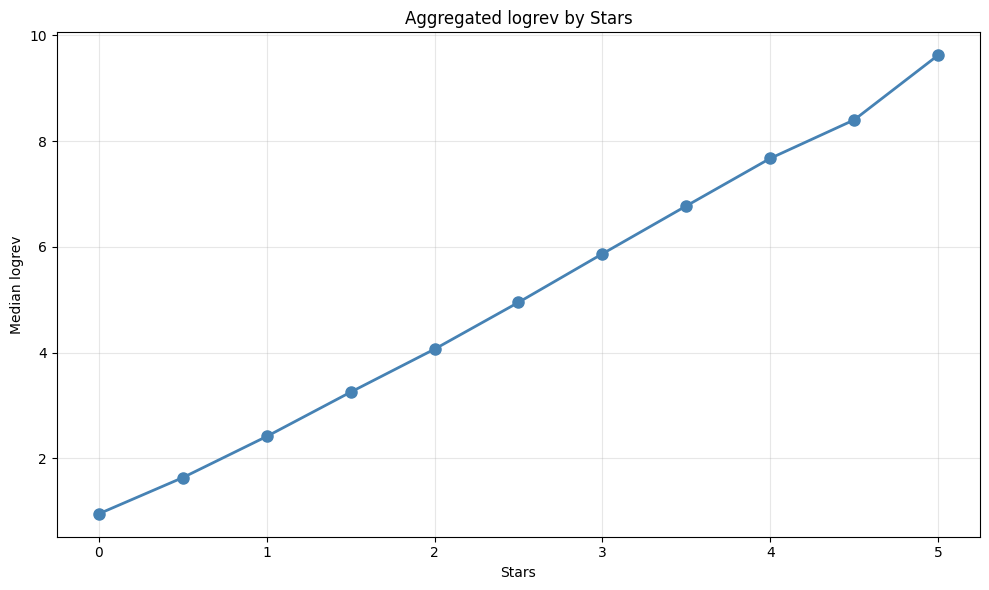

In [16]:
# Aggregate using median
agg_df = final_df.groupby('stars')['logrev'].agg(['median', 'count']).reset_index()
agg_df.columns = ['stars', 'median_logrev', 'count']

plt.figure(figsize=(10, 6))
plt.plot(agg_df['stars'], agg_df['median_logrev'], marker='o', linestyle='-', markersize=8, linewidth=2, color='steelblue')
plt.xlabel('Stars')
plt.ylabel('Median logrev')
plt.title('Aggregated logrev by Stars')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

this makes sense - better restaurants (more stars) should perform better financially

In [17]:
# summary stats
print(final_df.describe())

             logrev      rest_id          time         stars         score
count  15000.000000  15000.00000  15000.000000  15000.000000  15000.000000
mean       5.087827    750.50000      5.500000      2.532467      2.533021
std        3.348524    433.02704      2.872377      1.511136      1.501063
min       -5.900200      1.00000      1.000000      0.000000      0.000000
25%        2.632775    375.75000      3.000000      1.500000      1.265350
50%        5.077950    750.50000      5.500000      2.500000      2.555200
75%        7.503675   1125.25000      8.000000      4.000000      3.812900
max       15.472000   1500.00000     10.000000      5.000000      5.000000


In [18]:
summary_stats =final_df.groupby('stars')['logrev'].agg(['mean', 'std', 'count','min','max'])
print(summary_stats)


           mean       std  count      min      max
stars                                             
0.0    0.886451  1.994895   1113 -5.90020   6.9333
0.5    1.534720  2.116657   1155 -5.11770   7.7754
1.0    2.426008  2.095934   1436 -3.98070   9.2129
1.5    3.284028  2.068077   1472 -4.09020  10.1810
2.0    4.067074  2.126748   1438 -2.80040  10.2350
2.5    4.956311  2.065976   1468 -3.90160  11.9820
3.0    5.806986  2.065947   1548 -0.39344  12.3140
3.5    6.785788  2.133707   1440 -0.27531  13.5520
4.0    7.666847  2.052176   1507  1.25360  15.4720
4.5    8.377712  2.121082   1215  1.92700  14.9790
5.0    9.621206  1.952242   1208  2.78070  15.2710


<Axes: >

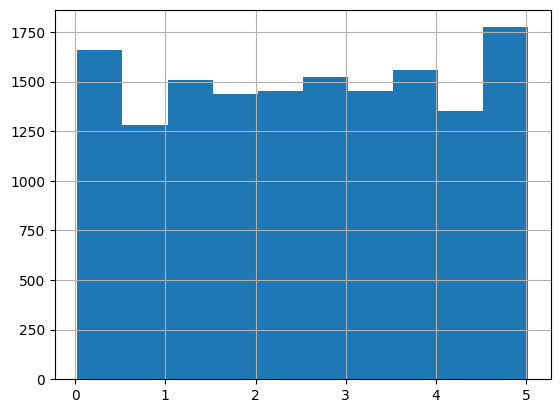

In [27]:
final_df.score_bin.hist()

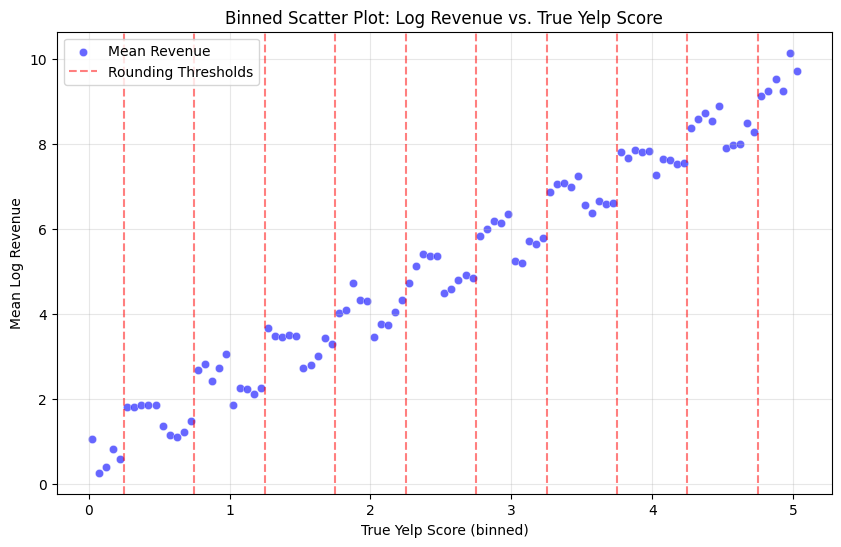

In [19]:
# create a (true) score bin
final_df['score_bin'] = (np.floor(final_df['score'] * 20) / 20) + 0.025 

# calculate mean revenue per bin
bin_revenue_data = final_df.groupby('score_bin')['logrev'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=bin_revenue_data, x='score_bin', y='logrev', color='blue', alpha=0.6)

thresholds = [0.25,0.75,1.25,1.75,2.25,2.75,3.25, 3.75, 4.25, 4.75]
for t in thresholds:
    plt.axvline(t, color='red', linestyle='--', alpha=0.5, label=f'Threshold {t}')

plt.title('Binned Scatter Plot: Log Revenue vs. True Yelp Score')
plt.xlabel('True Yelp Score (binned)')
plt.ylabel('Mean Log Revenue')
plt.legend(['Mean Revenue', 'Rounding Thresholds'])
plt.grid(True, alpha=0.3)
plt.show()

It does look like there are "jumps" around the thresholds... which means that there is definitely a revenue benefit to having a higher star rating. But, are restaurants manipulating the ratings?

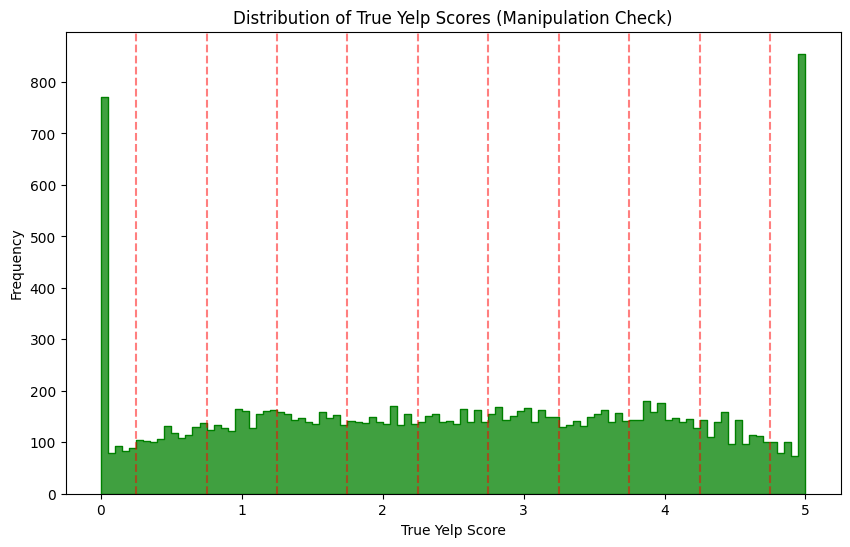

In [39]:
plt.figure(figsize=(10, 6))
sns.histplot(data=final_df, x='score', bins=100, kde=False, color='green', element="step")

# Add thresholds again for reference
for t in thresholds:
    plt.axvline(t, color='red', linestyle='--', alpha=0.5)

plt.title('Distribution of True Yelp Scores (Manipulation Check)')
plt.xlabel('True Yelp Score')
plt.ylabel('Frequency')
plt.show()

Doesn't look like it. We would see a lot of difference around the thresholds if restaurants were manipulating scores. Can run McCrary Density Test to verify quantitatively.

In [ ]:
# OLS Regression of logrev on score (ignoring the star rating thresholds). This assumes a smooth relationship (which we know is wrong from the plots)
model_a = smf.ols("logrev ~ score", data=final_df).fit()
print("Naive OLS Results on Score:")
print(model_a.summary().tables[1])
print("\n")


Naive OLS Results on Score:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6939      0.034     20.577      0.000       0.628       0.760
score          1.7347      0.011    151.461      0.000       1.712       1.757




1 point increase in score leads to a 173% increase in logrev.

In [ ]:
# Now add 'stars' to see if the slope of 'score' changes. Do 'stars' (the badge - i.e. what users see) matter more than 'score' (quality)? 

model_b = smf.ols("logrev ~ score + stars", data=final_df).fit()
print("OLS with Score + Stars")
print(model_b.summary().tables[1])
print("\n")



OLS with Score + Stars
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7133      0.033     21.483      0.000       0.648       0.778
score         -0.9976      0.125     -7.991      0.000      -1.242      -0.753
stars          2.7252      0.124     21.976      0.000       2.482       2.968




Stars coefficient (2.725): Holding score constant, a 1-star increase is associated with a 2.725 increase in log revenue.

In revenue terms: exp(2.725) ≈ 15.3  (a ~1,430% increase in revenue per star) i.e. stars have a massive association with revenue.

Score coefficient (–0.998): Holding stars fixed, a 1-unit increase in score is associated with a decrease in log revenue. Not sure why the sign flipped? is it because of multicollinearity?

Two restaurants have the same star rating, but one has a slightly higher underlying score -> this situation mostly happens within star bins.

While restaurant quality (score) appears highly predictive of revenue in isolation, this relationship is almost entirely mediated by star ratings; once star ratings are held fixed, incremental improvements in underlying quality do not translate into higher revenue.


Thoughts on why does the score sign flip...
- The extra latent quality not reflected in stars does not increase revenue.
- It may even slightly decrease it (possibly due to noise? pricing?).

In [35]:
# So how do we estimate the effect of that extra half star on revenue?
# create function to center the score around the nearest threshold

def centered_score(score):
    thresholds = np.array([0.25,0.75,1.25,1.75,2.25,2.75,3.25, 3.75, 4.25, 4.75])
    closest = thresholds[np.argmin(np.abs(thresholds - score))] # find the threshold that is closest to the restaurant's score
    treatment = 1 if score >= closest else 0
    return score - closest, treatment

final_df[['centered_score', 'treatment']] = (final_df['score'].apply(lambda x: pd.Series(centered_score(x))))
final_df.head()

,logrev,rest_id,time,stars,score,score_bin,centered_score,treatment
0,1.63390,1,1,1.0,1.1549,1.175,-0.0951,0.0
1,1.43880,2,1,1.0,1.0105,1.025,-0.2395,0.0
2,6.20120,3,1,3.5,3.6209,3.625,-0.1291,0.0
3,-0.34747,4,1,2.0,1.8283,1.825,0.0783,1.0
4,-0.22975,5,1,0.0,0.0000,0.025,-0.2500,0.0


<Axes: >

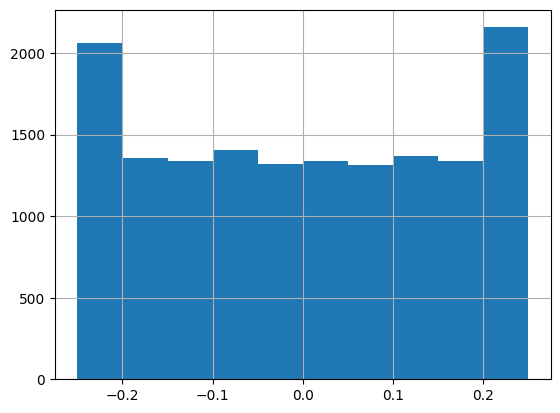

In [36]:
final_df.centered_score.hist()

### Implementing a Regression Discontinuity Design (RDD)...

In [37]:
# keep observations close to a cutoff (RDD must be local)
h = 0.15 # it looks like we can go up to +/- 0.20 based on the histogram, we would get scores farther from the cutoff and that would weaken the RDD assumption that scores close to the cutoff are similar
rd_df = final_df[np.abs(final_df['centered_score']) <= h]


In [38]:
# create bins of centered score for visualization only
rd_df['centered_bin'] = (np.floor(rd_df['centered_score'] * 20) / 20 + 0.025)

/var/folders/zt/286j3n8d48lfrnzpn8wh22lc0000gp/T/ipykernel_59634/2844939958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rd_df['centered_bin'] = (np.floor(rd_df['centered_score'] * 20) / 20 + 0.025)


In [39]:
# Compute average log revenue within each bin
plot_data = (rd_df.groupby('centered_bin')['logrev'].mean().reset_index())

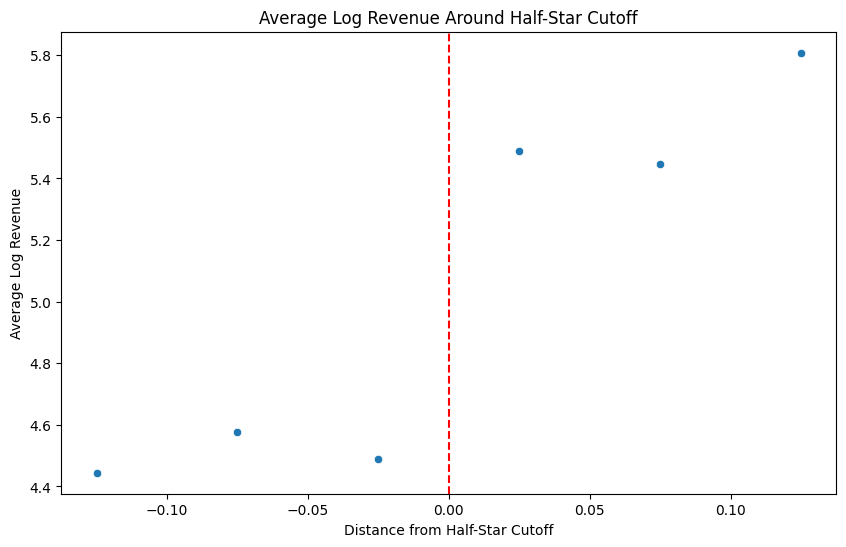

In [40]:
# Plot the binned averages
plt.figure(figsize=(10, 6))
sns.scatterplot(data=plot_data, x='centered_bin', y='logrev')
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Distance from Half-Star Cutoff')
plt.ylabel('Average Log Revenue')
plt.title('Average Log Revenue Around Half-Star Cutoff')
plt.show()

In [ ]:
# Manual implementation of RDD with interaction term
model_rd = smf.ols("logrev ~ centered_score * treatment",data=rd_df).fit(cov_type="HC1")


In [58]:
print(model_rd.summary().tables[1])


                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    5.1629      0.098     52.725      0.000       4.971       5.355
centered_score              -0.0711      1.137     -0.063      0.950      -2.299       2.157
treatment                    0.8156      0.138      5.911      0.000       0.545       1.086
centered_score:treatment     3.9477      1.583      2.493      0.013       0.845       7.051


Look at the treatment coefficient - gaining a half star results in an increase in revenue of e^(0.816) - 1 which is ~ 126% more. 

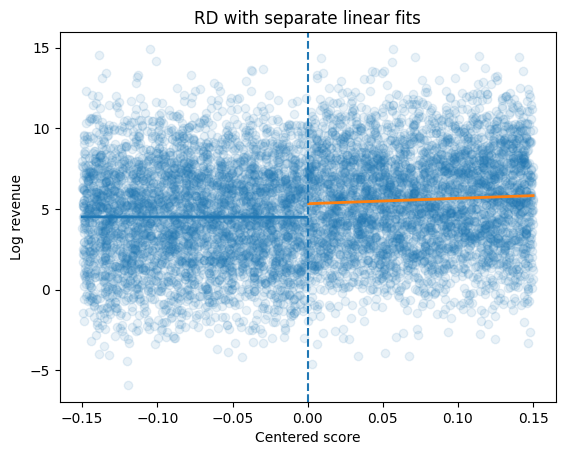

In [45]:
# grid around the cutoff
x_grid = np.linspace(-h, h, 200)

# predicted lines
y_left  = model_rd.params['Intercept'] + model_rd.params['centered_score'] * x_grid
y_right = (model_rd.params['Intercept'] + model_rd.params['treatment'] +
           (model_rd.params['centered_score'] + model_rd.params['centered_score:treatment']) * x_grid)

# plot
plt.scatter(rd_df['centered_score'], rd_df['logrev'], alpha=0.1)
plt.plot(x_grid[x_grid < 0], y_left[x_grid < 0], linewidth=2)
plt.plot(x_grid[x_grid >= 0], y_right[x_grid >= 0], linewidth=2)
plt.axvline(0, linestyle='--')
plt.xlabel("Centered score")
plt.ylabel("Log revenue")
plt.title("RD with separate linear fits")
plt.show()


Centered score is the distance from the nearest half-star threshold. Below the cutoff revenue has no trend with score. However, at the cutoff, there is a jump in revenue. 

In [ ]:
# using rdrobust package
rdrobust(y=final_df['logrev'].values,x=final_df['centered_score'].values,c=0)


Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                 15000
Polynomial Order Est. (p):                  1
Polynomial Order Bias (q):                  2
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                         NN

                                Left      Right
------------------------------------------------
Number of Observations          8698       6302
Number of Unique Obs.           5448       3223
Number of Effective Obs.        1600       1580
Bandwidth Estimation           0.072      0.072
Bandwidth Bias                 0.111      0.111
rho (h/b)                      0.644      0.644

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional       1.078    0.232    4.647   3.370e-06     [0.623, 1.532]
Robust     

1. rdrobust estimates a linear fit but quadratic bias correction.
2. Wider CI and SE indicate rdrobust is more conservative.
3. revenue increase ~ e^1.08 -1 = 194%


## Appendix

In [ ]:
# checking between HC1 and HC2. used HC1 because of large sample size and no leverage points.
model_hc1 = smf.ols("logrev ~ centered_score * treatment", data=rd_df).fit(cov_type="HC1")
model_hc2 = smf.ols("logrev ~ centered_score * treatment", data=rd_df).fit(cov_type="HC2")

print(model_hc1.summary().tables[1])
print(model_hc2.summary().tables[1])    


                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.4924      0.098     45.834      0.000       4.300       4.684
centered_score              -0.1707      1.146     -0.149      0.882      -2.416       2.075
treatment                    0.8394      0.138      6.077      0.000       0.569       1.110
centered_score:treatment     3.5080      1.604      2.187      0.029       0.365       6.652
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    4.4924      0.098     45.830      0.000       4.300       4.685
centered_score              -0.1707      1.146     -0.149      0.882      -2.416       2.075
treatment                    0.8394      0.138      6.076      0.000  

How does the choice of h make a difference?

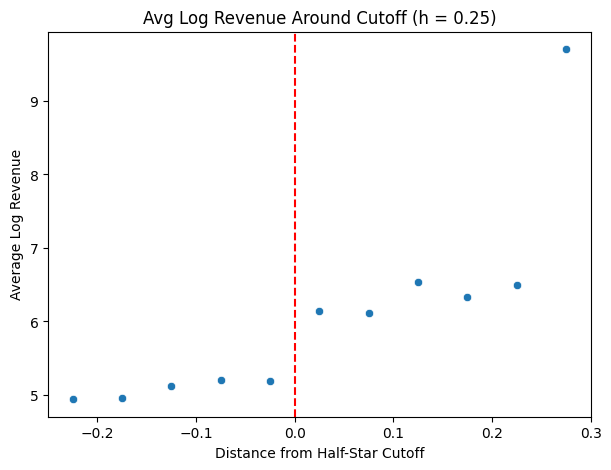

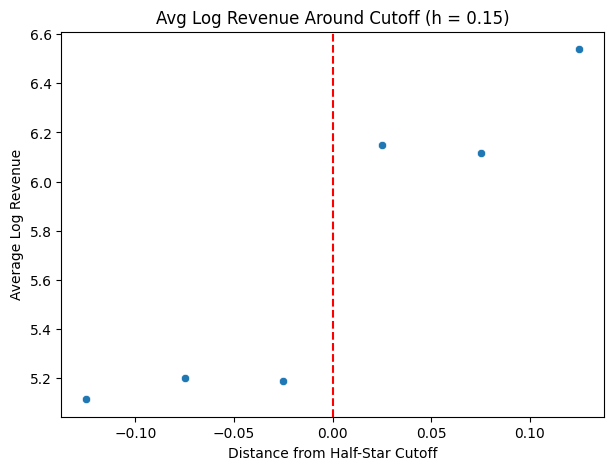

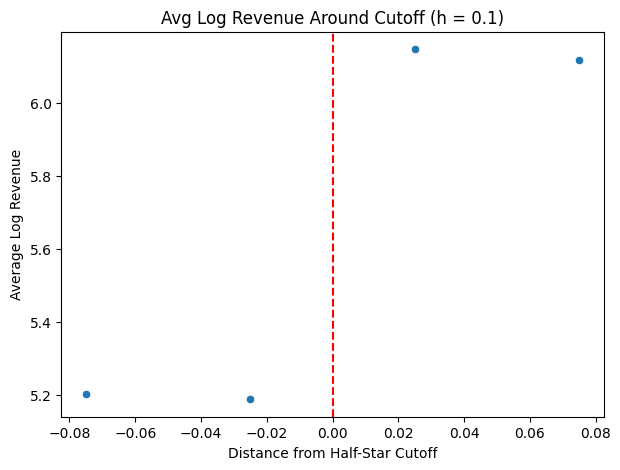

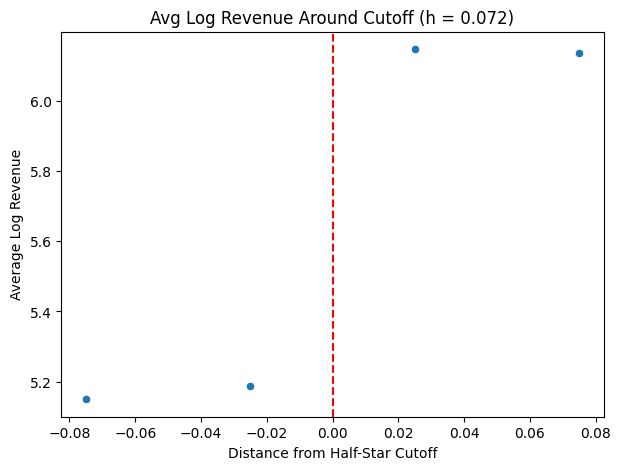

In [ ]:
bws = [0.25, 0.15, 0.10, 0.072]


for h in bws:
    # Restrict to observations within bandwidth
    rd_df = final_df[np.abs(final_df['centered_score']) <= h].copy()

    # Bin centered score (bin width = 0.05)
    rd_df['centered_bin'] = (np.floor(rd_df['centered_score'] * 20) / 20 + 0.025)

    # Compute mean log revenue in each bin
    plot_data = (
        rd_df
        .groupby('centered_bin')['logrev']
        .mean()
        .reset_index()
    )

    # Plot
    plt.figure(figsize=(7, 5))
    sns.scatterplot(data=plot_data, x='centered_bin', y='logrev')
    plt.axvline(0, color='red', linestyle='--')
    plt.title(f'Avg Log Revenue Around Cutoff (h = {h})')
    plt.xlabel('Distance from Half-Star Cutoff')
    plt.ylabel('Average Log Revenue')
    plt.show()

1. The discontinuity in log revenue at the half-star cutoff is visually evident and robust across a range of bandwidths. 
2. Wider bandwidths improve visual smoothness
3. more conservative and data-driven bandwidth choices yield noisier but consistent jumps